In [1]:
import sys
sys.path.append("/home/salmon/workspace/fytok/python")
sys.path.append("/home/salmon/workspace/SpDev/SpCommon")
sys.path.append("/home/salmon/workspace/SpDev/SpDB")

import collections
from spdm.util.logger import logger
from spdm.data.Collection import Collection
import matplotlib.pyplot as plt
import numpy as np
from scipy import special
import math

In [2]:
db = Collection("cfetr+mdsplus:///home/salmon/public_data/~t/",default_tree_name="efit_east")
entry = db.open(shot=55555).entry

2020-10-24 14:34:37,103 DEBUG [spdm] /home/salmon/workspace/SpDev/SpCommon/spdm/util/sp_export.py:76:sp_find_module: Can not find module spdm.data.plugins.Plugincfetr#cfetrCollection
2020-10-24 14:34:37,104 DEBUG [spdm] /home/salmon/workspace/SpDev/SpCommon/spdm/util/sp_export.py:76:sp_find_module: Can not find module spdm.data.plugins.PluginCfetr#CfetrCollection
2020-10-24 14:34:37,110 DEBUG [spdm] /home/salmon/workspace/SpDev/SpCommon/spdm/util/sp_export.py:74:sp_find_module: spdm.data.plugins.PluginCFETR#CFETRCollection
2020-10-24 14:34:37,112 INFO [spdm] /home/salmon/workspace/SpDev/SpDB/spdm/data/Plugin.py:77:find_plugin: Load Plugin: CFETRCollection
2020-10-24 14:34:37,148 DEBUG [spdm] /home/salmon/workspace/SpDev/SpCommon/spdm/util/sp_export.py:74:sp_find_module: spdm.data.plugins.PluginMDSplus#MDSplusCollection
2020-10-24 14:34:37,149 INFO [spdm] /home/salmon/workspace/SpDev/SpDB/spdm/data/Plugin.py:77:find_plugin: Load Plugin: MDSplusCollection
2020-10-24 14:34:37,150 DEBUG [s

In [4]:
COIL=collections.namedtuple("COIL", "label r z current turns")
def psi(r, z, coils):
    def green_function(Rc, Zc, R, Z):
        k2   =  4.0*Rc*R/((Rc+R)*(Rc+R)+(Zc-Z)*(Zc-Z))          
        return   math.sqrt(R*Rc)/(2.0*math.pi)* ((2.0-k2) * special.ellipk(k2) - 2.0* special.ellipe(k2))/math.sqrt(k2)  
    return sum([green_function(coil.r, coil.z, r, z)*coil.current for coil in coils])

In [5]:
vessel_inner_points= np.array([entry.wall.description_2d.vessel.annular.outline_inner.r.__value__(),    
                                          entry.wall.description_2d.vessel.annular.outline_inner.z.__value__()]).transpose([1,0]) 

vessel_outer_points= np.array([entry.wall.description_2d.vessel.annular.outline_outer.r.__value__(),    
                                          entry.wall.description_2d.vessel.annular.outline_outer.z.__value__()]).transpose([1,0])  


tf_inner_points= np.array([entry.tf.coil.outline_inner.r.__value__(),    
                                          entry.tf.coil.outline_inner.z.__value__()]).transpose([1,0]) 

tf_outer_points= np.array([entry.tf.coil.outline_outer.r.__value__(),    
                                          entry.tf.coil.outline_outer.z.__value__()]).transpose([1,0])  

limiter_points =  np.array([entry.wall.description_2d[0].limiter.unit[0].outline.r.__value__(),
                                 entry.wall.description_2d[0].limiter.unit[0].outline.z.__value__()]).transpose([1,0]) 

In [6]:
itime=30000

pf_coils=[] 
rpos=[]
zpos=[]
 
itime=40000
I0=[
    2,  #CS1U 
    5,  #CS2U
    5,  #CS3U
    6,  #CS4U
    2,  #CS4L
    2,  #CS3L
    2,  #CS2L
    1,  #CS1L
    1,  #PF1 
    -1, #PF2 
    1,  #PF3 
    1,  #PF4 
    -1, #PF5 
    0, #PF6 
    1   #PF7 
    ]
for idx,coil in enumerate(entry.pf_active.coil): 
    rect=coil.element[0].geometry.rectangle.__value__()
    rpos.append(rect.r-rect.width/2.0)
    rpos.append(rect.r+rect.width/2.0)
    zpos.append(rect.z-rect.height/2.0)
    zpos.append(rect.z+rect.height/2.0)  
    pf_coils.append(COIL(coil.name.__value__(),
     rect.r*1.0,rect.z*1.0, I0[idx],  (coil.element[0].turns_with_sign*1 ) ))
    # pf_coils.append(COIL(rect.r*1.0,rect.z*1.0,Ic[idx] ) )

rmin=min(rpos)
rmax=max(rpos)
zmin=min(zpos)
zmax=max(zpos)
NX=100
NY=100
X, Y  = np.meshgrid(np.linspace(rmin, rmax, NX),np.linspace(zmin, zmax, NY))
Z=np.ndarray([NX,NY])
for ix in range(NX):
    for iy in range(NY):
        Z[ix,iy]=psi(X[ix,iy],Y[ix,iy],pf_coils)

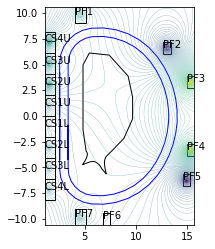

In [7]:
fg=plt.figure()

plt.gca().add_patch(plt.Polygon(limiter_points , fill=False,closed=True))

plt.gca().add_patch(plt.Polygon(tf_inner_points , fill=False,closed=True,color="blue"))
plt.gca().add_patch(plt.Polygon(tf_outer_points , fill=False,closed=True,color="blue"))

# plt.gca().add_patch(plt.Polygon(vessel_outer_points , fill=False,closed=True,color="green"))
# plt.gca().add_patch(plt.Polygon(vessel_inner_points , fill=False,closed=True,color="green"))


for coil  in entry.pf_active.coil:
    rect=coil.element[0].geometry.rectangle.__value__() 
    plt.text(rect.r-rect.width/2.0, float(rect.z),str(coil.name))
    plt.gca().add_patch(plt.Rectangle((rect.r-rect.width/2.0, rect.z-rect.height/2.0), rect.width, rect.height, fill=False))
 
# for idx,p in enumerate(tf_outer_points):
#     plt.text(p[0],p[1],idx)
plt.contour(X,Y,Z,levels=140,linewidths=0.2)

# plt.contour(
#     entry.equilibrium.time_slice[10].profiles_2d.grid.dim1.__value__(),
#     entry.equilibrium.time_slice[10].profiles_2d.grid.dim2.__value__(),
#     entry.equilibrium.time_slice[10].profiles_2d.psi.__value__(),
#     levels= 20,
#     linewidths=0.5)

plt.axis('scaled')
plt.show()

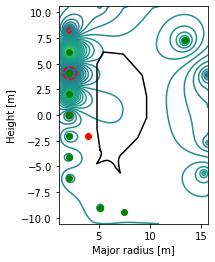

In [12]:
sys.path.append("/home/salmon/workspace/freegs/")
import freegs
from freegs.machine import Machine,Wall
import freegs.equilibrium as equilibrium
import freegs.jtor as jtor
import freegs.picard as picard
import freegs.boundary as boundary
from  freegs.coil import Coil

coils = []
for coil in entry.pf_active.coil:
    rect = coil.element[0].geometry.rectangle.__value__()
    
    coils.append((coil.name.__value__(), Coil(
                rect.r+rect.width/2, rect.z+rect.height/2, 
                turns=int(coil.element[0].turns_with_sign),
                area=rect.width*rect.height,
                control=True)))

wall = Wall(entry.wall.description_2d[0].limiter.unit[0].outline.r.__value__(),
            entry.wall.description_2d[0].limiter.unit[0].outline.z.__value__())

CFETRTokamak = Machine(coils=coils,wall=wall)


eq = equilibrium.Equilibrium(tokamak=CFETRTokamak,
                                Rmin=rmin,#min(limiter_points[0]),
                                Rmax=rmax,#max(limiter_points[0]),
                                Zmin=zmin,#min(limiter_points[1]),
                                Zmax=zmax,#max(limiter_points[1]),
                                nx=129, ny=129,
                                boundary=boundary.freeBoundaryHagenow)



# profiles = jtor.ConstrainPaxisIp(1e3,  # Plasma pressure on axis [Pascals]
#                             1e6,  # Plasma current [Amps]
#                             1.0)  # fvac = R*Bt

profiles = freegs.jtor.ConstrainPaxisIp(1e3, # Plasma pressure on axis [Pascals]
                                        1e5, # Plasma current [Amps]
                                        1.0) # fvac = R*Bt


# psivals = [ (R, Z, 0.0) for R, Z in zip(wall.R,wall.Z)]
# # psivals = [ (R, Z, 0.0) for R, Z in zip(entry.equilibrium.time_slice[10].boundary.outline.r.__value__(), 
# #             entry.equilibrium.time_slice[10].boundary.outline.z.__value__()) ]

xpoints = [(6, -5),   # (R,Z) locations of X-points
           (6, 5)]

isoflux = [(6,-5, 6,4)] # (R1,Z1, R2,Z2) pair of locations

constrain = freegs.control.constrain(xpoints=xpoints, isoflux=isoflux)

freegs.solve(eq, profiles,constrain,maxits=500,show=True,psi_bndry=0.0) 


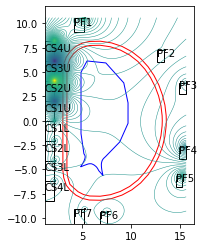

In [11]:
fg=plt.figure()

plt.gca().add_patch(plt.Polygon(limiter_points , fill=False,closed=True,color="blue"))
plt.gca().add_patch(plt.Polygon(vessel_inner_points , fill=False,closed=True,color="red"))
plt.gca().add_patch(plt.Polygon(vessel_outer_points , fill=False,closed=True,color="red"))

for coil  in entry.pf_active.coil:
    rect=coil.element[0].geometry.rectangle.__value__() 
    plt.text(rect.r-rect.width/2.0, float(rect.z),str(coil.name))
    plt.gca().add_patch(plt.Rectangle((rect.r-rect.width/2.0, rect.z-rect.height/2.0), rect.width, rect.height, fill=False))
 
for label,coil  in coils:       
    plt.gca().add_patch(plt.Rectangle((coil.R, coil.Z), 0.1,0.1, fill=False))
 
plt.contour(np.linspace(rmin,rmax,129),np.linspace(zmin,zmax,129),eq.psi().transpose(-1,0),levels= 340,linewidths=0.5)

# plt.contour(X,Y,Z,levels=140,linewidths=0.2)

# plt.contour(
#     entry.equilibrium.time_slice[10].profiles_2d.grid.dim1.__value__(),
#     entry.equilibrium.time_slice[10].profiles_2d.grid.dim2.__value__(),
#     entry.equilibrium.time_slice[10].profiles_2d.psi.__value__(),
#     levels= 20,
#     linewidths=0.5)

plt.axis('scaled')
plt.show()